Dirichlet Processes: forward sampling and posterior inference with truncated stick breaking construction.

translated from 

https://ericmjl.github.io/dl-workshop/04-gaussian-clustering/02-dirichlet-processes.html 

and 

https://ericmjl.github.io/dl-workshop/04-gaussian-clustering/03-dirichlet-process-clustering.html 

In [2]:
from functools import partial
import jax.numpy as jnp
from jax.scipy import stats
from jax.scipy.special import logsumexp
from jax import vmap, random, lax, value_and_grad

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

import matplotlib.pyplot as plt
import seaborn as sns

The stick-breaking definition of the Dirichlet process (DP) with concentration parameter $\alpha$ is
\begin{align*}
G &= \sum_{i=1}^{\infty} \pi_i \delta_{\theta_i} \\
\pi_i &= \beta_i\prod_{j=1}^{i-1}(1-\beta_i) \\
\beta_i &\overset{i.i.d.}{\sim} \text{Beta}(1, \alpha) 
\end{align*}

The stick-breaking definition of DP indicates that we can sample from a DP sequentially by samples from beta distribution.
Since it is computationally intractable to deal with infinite weights $\pi_i$, $i=1, 2, \cdots$ of a sample from DP, in practice we can truncate the sequence to finite length during simulation.  

/home/xinglong/.local/lib/python3.8/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


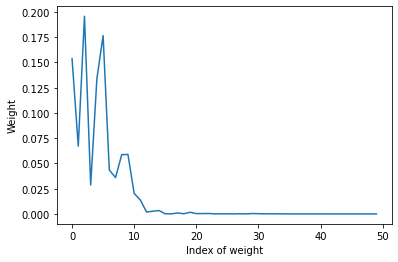

In [3]:
# Visualizing the stick-breaking construction of a DP:
def dp_stick_break_sample(key, concentration, num_of_components):
    beta_samples = random.beta(key=key, a=1, b=concentration, shape=(num_of_components,))

    def weighting(accumulated_probability, beta_i):
        weight_i = (1 - accumulated_probability) * beta_i
        return accumulated_probability + weight_i, weight_i

    accumulated_probability, weights = lax.scan(weighting, jnp.array(0.0), beta_samples)
    # Normalizing the weights
    weights /= jnp.sum(weights)
    return accumulated_probability, weights


key = random.PRNGKey(0)
accumulated_probability, weights = dp_stick_break_sample(key, 3, 50)
plt.plot(weights)
plt.xlabel("Index of weight")
plt.ylabel("Weight")
savefig("dp_stick_breaking_samples")

<AxesSubplot:>

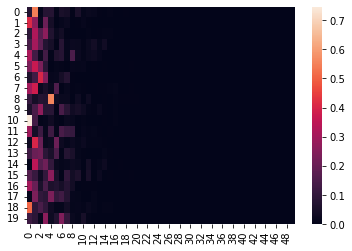

In [27]:
# Multiple samples from DP
def dp_multiple_samples(key, concentration, num_of_samples):
    # Generating multiple samples from the DP with one concentration parameter using the stick-breaking approach
    keys = random.split(key, num_of_samples)
    accumulated_probabilities, weights_samples = vmap(
        partial(dp_stick_break_sample, concentration=concentration, num_of_components=50)
    )(keys)
    return accumulated_probabilities, weights_samples


key, subkey = random.split(key)
accumulated_probabilities, weights_samples = dp_multiple_samples(subkey, concentration=3, num_of_samples=20)
sns.heatmap(weights_samples)

As is visible above, when concentration parameter $\alpha = 3$, most of the probability mass is concentrated at roughly the first 5-8 items.

We explore the effect of the concentration parameter on DP by plotting samples from DPs with differerent values of the concentration paramter.

/home/xinglong/.local/lib/python3.8/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


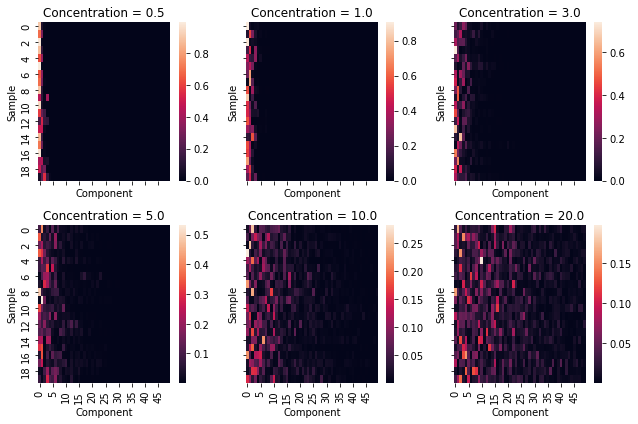

In [28]:
concentrations = jnp.array([0.5, 1, 3, 5, 10, 20])
key, *subkeys = random.split(key, len(concentrations) + 1)
accumulated_probabilites, weights_samples = vmap(partial(dp_multiple_samples, num_of_samples=20))(
    jnp.array(subkeys), concentrations
)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(3 * 3, 3 * 2), sharex=True, sharey=True)
for ax, weights_mat, conc in zip(axes.flatten(), weights_samples, concentrations):
    sns.heatmap(weights_mat, ax=ax)
    ax.set_title(f"Concentration = {conc}")
    ax.set_xlabel("Component")
    ax.set_ylabel("Sample")
plt.tight_layout()
savefig("stick_breaking_heatmap_montage")

It can be seen from the plots above that as the concentration parameter increases, the random probability measure sampled from DP becomes less concentrated, which means:
1. The probability mass allocated to the components that have significant probability mass decreases;
2. More components have relatively "significant" amounts of probability mass allocated.

The stick-breaking construction of DP also enables us to evaluate the likelihood of the DP sample under the beta distribution. 
The first step is to reverse the stick-breaking procedure and obtain the beta-distributed variables from the DP sample.

In [6]:
def beta_sample_from_weights(weights):
    # Transforming weights of a DP sample backwards to samples of beta distribution
    # by inversing the stick-breaking procedure.
    def beta_from_w(accumulated_probability, weights_i):
        log_beta_i = jnp.log(weights_i) - jnp.log(1 - accumulated_probability)
        newly_accumulated_probability = accumulated_probability + weights_i
        return newly_accumulated_probability, jnp.exp(log_beta_i)

    final, betas = lax.scan(beta_from_w, jnp.array(0.0), weights)
    return final, betas

We compare the true $\beta$ s used in the stick-breaking construction to the $\hat{\beta}$ s inferred with the backwards transterring algorithm. Notice that the inverse transformation is not exact because we truncated and renormalized the sequence of weights when sampling from the DP using stick-breaking procedure, and in practice we do not know the original accumulated probability given the sample of DP.

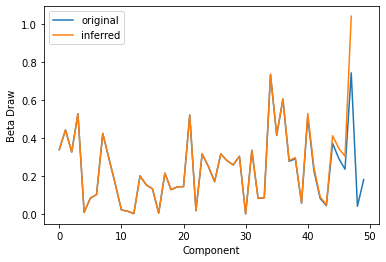

In [7]:
key, subkey = random.split(key)
beta_samples = random.beta(key=subkey, a=1, b=3, shape=(50,))


def weighting(accumulated_probability, beta_i):
    weight_i = (1 - accumulated_probability) * beta_i
    return accumulated_probability + weight_i, weight_i


accumulated_probability, weights = lax.scan(weighting, jnp.array(0.0), beta_samples)
weights /= jnp.sum(weights)
final, beta_hat = beta_sample_from_weights(weights)

plt.plot(beta_samples, label="original")
plt.plot(beta_hat, label="inferred")
plt.legend()
plt.xlabel("Component")
plt.ylabel("Beta Draw")
savefig("beta_process_truncated_samples")

We can then evaluate the likelihood of the DP sample as the joint likelihood of $\hat{\beta}$'s obtained with the inverse transformation.

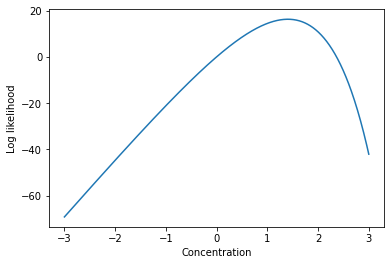

In [8]:
def loglike_weights(log_weights, log_concentration, num_of_components):
    weights = jnp.exp(log_weights)
    weights /= jnp.sum(weights)
    _, beta_samples = beta_sample_from_weights(weights)
    return jnp.sum(stats.beta.logpdf(x=beta_samples[:num_of_components], a=1, b=jnp.exp(log_concentration)))


# visualization of the log-likelihood of the DP sample as a function of the concentration parameter
log_concentrations = jnp.linspace(-3, 3, 1000)
loglike_of_weights = vmap(loglike_weights, in_axes=(None, 0, None))(jnp.array(jnp.log(weights)), log_concentrations, 25)
plt.plot(log_concentrations, loglike_of_weights)
plt.xlabel("Concentration")
plt.ylabel("Log likelihood")
savefig("beta_process_loglik_vs_concentration")

Given the likelihood function, we can obtain the maximum likelihood estimate (MLE) of the concentration parameter of the DP. If we define the loss function of the concentration parameter to be the negative of its likelihood, to maximize the likelihood is equivalent to minimize this loss function.

With Jax, it is straightforward to take the gradient descent approach in search of the MLE, where we make use of the 'grad' function to compute the gradient automatically.

In [9]:
# Defining the loss function, which is the negative log likelihood, as a function of number of components
def make_loss_dp(num_of_components):
    def loss_dp_inner(log_concentration, log_weights):
        vm_func = partial(loglike_weights, log_concentration=log_concentration, num_of_components=num_of_components)
        loglike_of_weights = vmap(vm_func, in_axes=0)(log_weights)
        return -jnp.sum(loglike_of_weights)

    return loss_dp_inner

In [12]:
# Defining the gradient descent loop
def fit(loss, optimizer, data, initial_params, T=1000):
    def step(carry, _):
        params, opt_state = carry
        loss_value, grads = value_and_grad(loss)(params, data)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss_value

    carry = (initial_params, optimizer.init(initial_params))
    final_params, loss_history = lax.scan(step, carry, xs=None, length=T)
    return final_params, loss_history

In [13]:
# Initialization
loss = make_loss_dp(num_of_components=25)
optimizer = optax.adam(learning_rate=0.05)
log_concentration_init = random.normal(key, (1,))
initial_params = log_concentration_init
data = jnp.log(weights_samples[3] + 1e-6)

In [14]:
# Model fitting
(final_params, final_state), loss_history = fit(loss, optimizer, data, initial_params)

/home/xinglong/.local/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


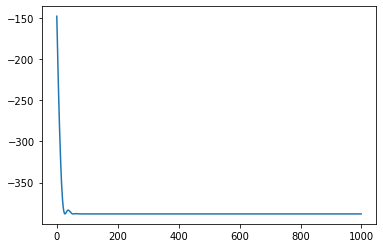

In [15]:
plt.plot(loss_history)

In [16]:
# The MLE
jnp.exp(final_params)

DeviceArray([4.793698], dtype=float32)

Gaussian mixture models are widely used in distribution approximation and clustering analysis. However, in practice the number of components of the mixture distribution is usually not known.

In the low diension space (e.g. 1-d), we can roughly read the number of components in the mixture distribution from the histogram of the samples:

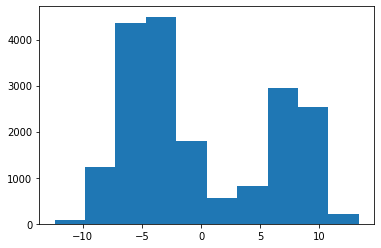

In [17]:
# A mixture gaussian distribution with 4 components.
weights_true = jnp.array([2, 10, 1, 6])
locs_true = jnp.array([-2.0, -5.0, 3.0, 8.0])
scale_true = jnp.array([1.1, 2.0, 1.0, 1.5])

base_n_draws = 1000
key = random.PRNGKey(42)
keys = random.split(key, 4)

# Sampling from the mixture distribution
samples_mixture = []
for i in range(4):
    shape = (int(base_n_draws * weights_true[i]),)
    samples = scale_true[i] * random.normal(keys[i], shape=shape) + locs_true[i]
    samples_mixture.append(samples)
data_mixture = jnp.concatenate(samples_mixture)

# We can read the number of components from the histogram.
_ = plt.hist(data_mixture)

However, even in the 1-d space, it is not always obvious to read the number of modes in a mixture distribution from the histogram. The information starts blurring as we increase the number of bins in the histogram.

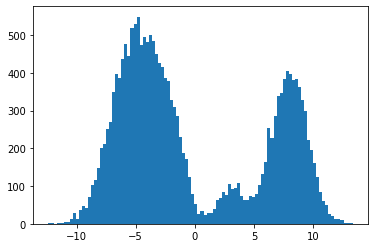

In [18]:
_ = plt.hist(data_mixture, bins=100)

Where the number of clusters is not clear, we can turn to DP mixture models, which does not impose an exact number of clusters, but controls the number of clusters probabilistically with a single concentration parameter.

Here we fit a DP Gaussian mixture model (DP-GMM) to above data and learn 
1. the concentration parameter of the DP,
2. the optimal relative weighting of components, conditioned on concentration parameters, and
3. distribution paraemters for each component, conditioned on the data.

We define the Bayesian model and try to obtain the maxinum a posterior (MAP) estimation of the these parameters. This is equivalent to miaximize the joint likelihood of these parameters and the data. Since we do not assign a prior distribution for the concentration parameter of the DP, the estimation of the concentration parameter can be seen as an empirical Bayesian approach.

To fit the DP mixture model using the gradient descent algorithm, we firstly defining the joint log likelihood of the DP mixture model, which is the negative loss function to be optimized.
The joint log likelihood of the DP mixture model is the summation of the log likelihood of data under the Gaussian mixture distribution and the log likelihood of the weights of mixture components. We have defined the later part using the beta distribution in our earlier discussion, and here we define the function that computes the log likelihood of data under the Gaussian mixture distribution.

In [19]:
def mixture_loglike(log_weights, component_mus, log_component_scales, data):
    def mixture_loglike_per_datum(log_weights, component_mus, log_component_scales, datum):
        log_weights -= logsumexp(log_weights)
        loglike_components = stats.norm.logpdf(datum, component_mus, jnp.exp(log_component_scales))
        loglike_components_weighted = log_weights + loglike_components
        return logsumexp(loglike_components_weighted)

    loglike_data = vmap(partial(mixture_loglike_per_datum, log_weights, component_mus, log_component_scales))(data)
    return jnp.sum(loglike_data)


# Defining the joint likelihood
def joint_loglike(log_weights, log_concentration, num_components, component_mus, log_component_scales, data):
    probs_ll = loglike_weights(log_weights, log_concentration, num_components)
    mix_ll = mixture_loglike(log_weights, component_mus, log_component_scales, data)
    return probs_ll + mix_ll

We can now start fitting the DP mixture model.

In [20]:
# Difining the loss function as a function of the number of components
def make_joint_loss(num_components):
    def inner(params, data):
        log_component_weights = params["log_component_weight"]
        log_concentration = params["log_concentration"]
        component_mus = params["component_mus"]
        log_component_scales = params["log_component_scale"]
        dp_log_like = joint_loglike(
            log_component_weights, log_concentration, num_components, component_mus, log_component_scales, data
        )
        return -dp_log_like

    return inner

In [21]:
# Defining the gradient descent loop
def fit(loss, optimizer, data, initial_params, T=1000):
    def step(carry, _):
        params, opt_state = carry
        loss_value, grads = value_and_grad(loss)(params, data)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), (params, loss_value)

    carry = (initial_params, optimizer.init(initial_params))
    final_params, (params_history, loss_history) = lax.scan(step, carry, xs=None, length=T)
    return params_history, loss_history

In [22]:
# Initialization
k1, k2, k3, k4 = random.split(key, 4)
n_components = 50

log_component_weights_init = random.normal(k1, shape=(n_components,))
log_concentration_init = random.normal(k2, shape=(1,))
component_mus_init = random.normal(k3, shape=(n_components,))
log_component_scales_init = random.normal(k4, shape=(n_components,))

initial_params = {
    "log_component_weight": log_component_weights_init,
    "log_concentration": log_concentration_init,
    "component_mus": component_mus_init,
    "log_component_scale": log_component_scales_init,
}
loss = make_joint_loss(num_components=25)
optimizer = optax.adam(learning_rate=0.05)
log_concentration_init = random.normal(key, (1,))
data = data_mixture

In [23]:
# Model fitting
params_history, loss_history = fit(loss, optimizer, data, initial_params, T=10_000)

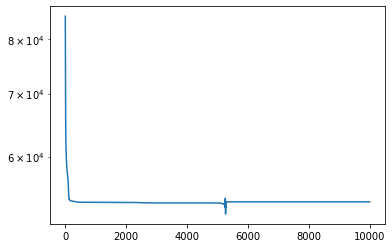

In [24]:
# Plotting the loss during the fitting process
plt.plot(loss_history)
plt.yscale("log")

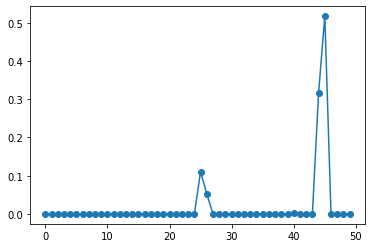

In [25]:
# Plotting the relative weights of each component
# It can be seen that the DP mixture model correctly selects 4 components out of 50.
opt_component_weights = jnp.exp(params_history["log_component_weight"][-1])
opt_component_weights /= jnp.sum(opt_component_weights)
plt.plot(opt_component_weights, marker="o")